## Figure_4_latent_space
Modified slightly from the utility script used in

Paper: [Neural networks to learn protein sequence-function relationships from deep mutational scanning data](https://www.biorxiv.org/content/10.1101/2020.10.25.353946v3)

Git-repo: https://github.com/gitter-lab/nn4dms/blob/master/notebooks/latent_space.ipynb

available under the MIT License, Copyright (c) 2020 Sam Gelman, Philip Romero, Anthony Gitter

### Attention 
* Installation of nn4dms engine is required for running the following script.
(fastest way: replacing everything under nn4dms/pub with our repo) 
* Datasets are pre-processed and integrated in the engine for running the following script.
* Source datasets are provided in Data/Source_Data/ in our repo.
(following the instructions here https://github.com/gitter-lab/nn4dms/blob/master/data/README.md for parsing independent inputs out of engine.)

In [1]:
import os
from os.path import abspath
import sys
os.chdir("../../")
module_path = abspath("code")
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Essential
import numpy as np
import tensorflow as tf
import umap
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# nn4dms libs
import constants
import utils
import encode as enc
import inference as inf
from split_dataset import load_split_dir

In [3]:
# load full dataset
ds = utils.load_dataset(ds_name="rbd")

# load the train-tune-test split used to train the model
ds_split = load_split_dir("pub/Trained_Models/Spike_RBD/Expression/split")

# model 1xk5f8
model1_prefix = "pub/Trained_Models/Spike_RBD/Expression/SPIKERBD_expr_cnn1xk5f8"
sess1 = inf.restore_sess(model1_prefix)
# model 1xk5f32
model2_prefix = "pub/Trained_Models/Spike_RBD/Expression/SPIKERBD_expr_cnn1xk5f32"
sess2 = inf.restore_sess(model2_prefix)
# model 2xk5f32
model3_prefix = "pub/Trained_Models/Spike_RBD/Expression/SPIKERBD_expr_cnn2xk5f32"
sess3 = inf.restore_sess(model3_prefix)
# model 3xk5f32
model4_prefix = "pub/Trained_Models/Spike_RBD/Expression/SPIKERBD_expr_cnn3xk5f32"
sess4 = inf.restore_sess(model4_prefix)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from pub/Trained_Models/Spike_RBD/Expression/SPIKERBD_expr_cnn1xk5f8
INFO:tensorflow:Restoring parameters from pub/Trained_Models/Spike_RBD/Expression/SPIKERBD_expr_cnn1xk5f32
INFO:tensorflow:Restoring parameters from pub/Trained_Models/Spike_RBD/Expression/SPIKERBD_expr_cnn2xk5f32
INFO:tensorflow:Restoring parameters from pub/Trained_Models/Spike_RBD/Expression/SPIKERBD_expr_cnn3xk5f32


In [4]:
rbd_test_set_df = ds.iloc[ds_split["test"]]
rbd_test_set_df

,variant,num_mutations,score
1978,D427M,1,-0.48
22,N334C,1,-0.57
841,S373C,1,-0.24
515,R357N,1,0.04
932,F377K,1,-2.42
...,...,...,...
2073,C432A,1,-3.01
3302,F490P,1,-0.13
2577,F456C,1,-0.29
3536,N501S,1,-0.03


In [5]:
encoded_variants = enc.encode(encoding="one_hot,aa_index", variants=rbd_test_set_df["variant"].tolist(), ds_name="rbd")
outputs = []

out = inf.run_inference(encoded_data=encoded_variants, sess=sess1, output_tensor_name="dense1/LeakyRelu:0")
outputs.append(out)

out = inf.run_inference(encoded_data=encoded_variants, sess=sess2, output_tensor_name="dense1/LeakyRelu:0")
outputs.append(out)

out = inf.run_inference(encoded_data=encoded_variants, sess=sess3, output_tensor_name="dense1/LeakyRelu:0")
outputs.append(out)

out = inf.run_inference(encoded_data=encoded_variants, sess=sess4, output_tensor_name="dense1/LeakyRelu:0")
outputs.append(out)

100%|██████████| 13/13 [00:00<00:00, 296.15it/s]


In [6]:
def get_umap_embedding(network_outputs, umap_params):
    if len(network_outputs.shape) > 2:
        network_outputs = network_outputs.reshape(network_outputs.shape[0], -1)
    reducer = umap.UMAP(random_state=7, **umap_params)
    mapper = reducer.fit(network_outputs)
    embedding = mapper.transform(network_outputs)
    return mapper, embedding

In [7]:
network_names = ["Network 1", "Network 2", "Network 3", "Network 4"]
embeddings = []
for network_name, network_output in zip(network_names, outputs):
    umap_params = {"n_neighbors": 15, "min_dist": 0.1, "metric": "euclidean"}
    mapper, embedding = get_umap_embedding(network_output, umap_params)
    embeddings.append(embedding)

Computing UMAP for layer: Network 1
Computing UMAP for layer: Network 2
Computing UMAP for layer: Network 3
Computing UMAP for layer: Network 4


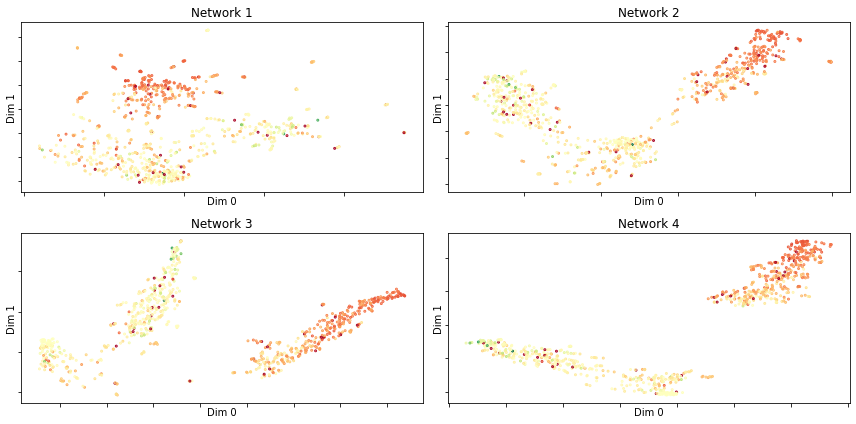

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axes = axes.flatten()
for i in range(len(network_names)):
    network_name = network_names[i]
    embedding = embeddings[i]
    ax = axes[i]
    divnorm = colors.TwoSlopeNorm(vmin=rbd_test_set_df["score"].min(), vcenter=0, vmax=rbd_test_set_df["score"].max())
    ax.scatter(embedding[:, 0], embedding[:, 1], c=rbd_test_set_df["score"], cmap="RdYlGn", norm=divnorm,
               s=0.8, alpha=1, marker="o", linewidth=2)
    ax.set(title=network_name, xlabel="Dim 0")
    ax.tick_params(labelbottom=False, labelleft=False)
    axes[i].set(ylabel="Dim 1")

plt.tight_layout()
plt.show()
#plt.savefig('latent_plot.png')  
plt.close(fig)